### 12. Clustering: Profiling Regional Vulnerability

**Objective:**
To identify distinct "Vulnerability Tiers" among Philippine regions using unsupervised machine learning.

**Methodology (Thesis Section 3.7):**
Instead of arbitrarily labeling regions as "Poor" or "Rich," we use **K-Means Clustering** to find natural statistical groupings in the data.
1.  **Feature Selection:** We cluster based on the three sub-dimensions (Sensitivity, Resilience, Exposure) to capture the *structure* of vulnerability.
2.  **Optimal K Detection:** We use the **Elbow Method** to statistically determine the natural number of groups, minimizing researcher bias.
3.  **Profiling:** We analyze the average scores of each cluster to define them (e.g., "High Vulnerability Cluster").

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import json
from pathlib import Path

# --- Config & Setup ---
# Loading from the central config ensures we grab the exact file produced by Notebook 11
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
INPUT_FILE = BASE_PATH / "RFVI_Results" / "Regional_Financial_Vulnerability_Index.csv"
OUTPUT_DIR = BASE_PATH / "RFVI_Results"

# Load Data
df = pd.read_csv(INPUT_FILE)
print(f"Data Loaded: {df.shape[0]} regional records.")

# --- Feature Selection ---
# CRITICAL: We cluster on the *components* (Sensitivity, Inv_Resilience, Exposure), 
# NOT the final RFVI score. This allows the algorithm to group regions that 
# are vulnerable for the *same reasons* (e.g., high exposure vs. low resilience).
features = ['Sensitivity_Norm', 'Inv_Resilience', 'Exposure_Norm']
X = df[features]

Data Loaded: 118 regional records.


### Step 1: The Bias Check (Elbow Method)
**The Problem:** How do we know if there are 2, 3, or 4 groups?
**The Solution:** We run the algorithm multiple times (from k=1 to k=10) and calculate the "Error" (Inertia).
* **Interpretation:** We look for the "Elbow" in the chart—the point where adding more clusters stops giving us major improvements. This makes our choice of "3 Clusters" mathematically defensible, not just a guess.

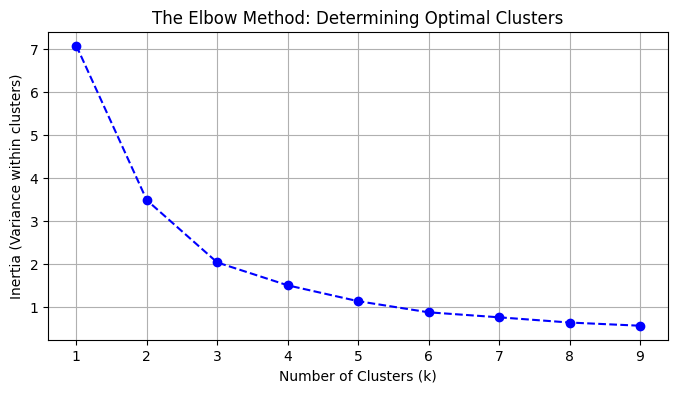

In [2]:
inertia = []
K_range = range(1, 10)

# Test different numbers of clusters
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

# Visualize
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.title('The Elbow Method: Determining Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Variance within clusters)')
plt.grid(True)
plt.show()

### Step 2: Clustering & Automated Labeling
**The Logic:**
The Elbow method usually suggests **3 clusters** for this type of data.
* **Auto-Labeling:** The algorithm assigns random IDs (0, 1, 2). To make sense of this, we calculate the **Average RFVI** for each group and sort them.
    * **Tier 1:** The Lowest Vulnerability Group (Best).
    * **Tier 2:** The Moderate Vulnerability Group.
    * **Tier 3:** The Highest Vulnerability Group (Worst).
    
*This ensures that "Tier 3" always means "High Risk," regardless of what random number the computer picked.*

In [3]:
# 1. Initialize Model (Standard k=3 based on policy tiers: Low, Med, High)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# 2. Fit and Predict
df['Cluster_ID'] = kmeans.fit_predict(X)

# 3. AUTOMATED RELABELING (Safe & Unbiased)
# Calculate the mean RFVI for each ID
cluster_ranks = df.groupby('Cluster_ID')['RFVI'].mean().sort_values().index

# Create a mapping: Lowest RFVI -> 1, Highest RFVI -> 3
rank_map = {id_: i+1 for i, id_ in enumerate(cluster_ranks)}

# Apply the mapping
df['Cluster_Label'] = df['Cluster_ID'].map(rank_map)

# Save Results
df.to_csv(OUTPUT_DIR / "Regional_Clusters_Final.csv", index=False)

print("Clustering Complete.")
print("Cluster Counts:")
print(df['Cluster_Label'].value_counts().sort_index())

Clustering Complete.
Cluster Counts:
Cluster_Label
1    20
2    65
3    33
Name: count, dtype: int64


### Step 3: Cluster Profiling (The "Personality" of Each Group)
**Why we need this:**
The panel will ask: *"What makes Cluster 3 different from Cluster 1?"*
**The Evidence:**
The table below shows the average scores.
* If **Cluster 3** has high *Sensitivity* and high *Inv_Resilience*, it means these regions are unstable AND lack the capacity to cope.
* If **Cluster 1** has low *Exposure*, it means they are geographically or structurally safer.

In [4]:
# Group by our new Tiers (1, 2, 3)
profile = df.groupby('Cluster_Label')[['Sensitivity_Norm', 'Resilience_Norm', 'Exposure_Norm', 'RFVI']].mean()

print("\n--- CLUSTER CHARACTERISTICS ---")
print(profile)
print("\n-------------------------------")

# Interpretation Helper
print("INTERPRETATION GUIDE:")
print(f"Tier 1 (Low Vuln):  Avg RFVI = {profile.loc[1, 'RFVI']:.3f} (Best Performance)")
print(f"Tier 3 (High Vuln): Avg RFVI = {profile.loc[3, 'RFVI']:.3f} (Worst Performance)")


--- CLUSTER CHARACTERISTICS ---
               Sensitivity_Norm  Resilience_Norm  Exposure_Norm      RFVI
Cluster_Label                                                            
1                           0.0         0.847518       0.143548  0.098677
2                           0.0         0.475061       0.180540  0.235160
3                           0.0         0.238607       0.302072  0.354488

-------------------------------
INTERPRETATION GUIDE:
Tier 1 (Low Vuln):  Avg RFVI = 0.099 (Best Performance)
Tier 3 (High Vuln): Avg RFVI = 0.354 (Worst Performance)


### Step 4: Final Visualizations
**Figure 1: The Landscape (Scatterplot)**
* **X-Axis:** Overall Vulnerability (RFVI).
* **Y-Axis:** Resilience Capacity.
* **Interpretation:** We expect a downward trend. Regions with *High Resilience* (Top) should have *Low Vulnerability* (Left). Regions in the "Danger Zone" (Tier 3) will be Bottom-Right.

**Figure 2: The Rankings (Bar Chart)**
* **Why:** This answers Research Question 3 (Ranking).
* **Logic:** We filter for the **latest year** (2024) to give current policy recommendations. The bars are colored by their Cluster Tier to show which regions are in critical condition.

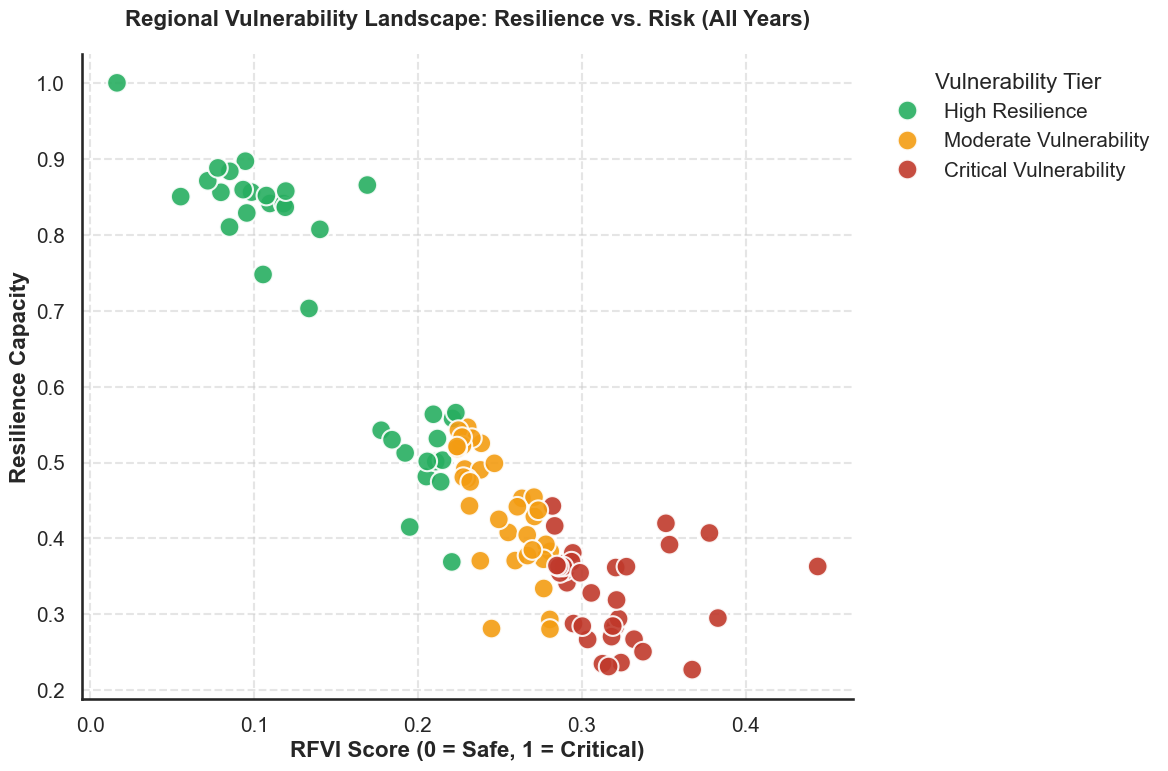

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Configuration ---
sns.set_style("white")
sns.set_context("talk", font_scale=0.9)
plt.rcParams['font.family'] = 'sans-serif'

# --- 2. Data Cleaning & Aggregation ---
# Standardize region names to uppercase to merge duplicates
df['region'] = (df['region'].astype(str)
                .str.lower()
                .str.replace(r'\s+', ' ', regex=True)
                .str.strip()
                .str.upper())

# Aggregate to Annual Averages
annual_df = df.groupby(['Year', 'region']).agg({
    'RFVI': 'mean',
    'Resilience_Norm': 'mean'
}).reset_index()

# --- 3. Vulnerability Classification ---
# Thresholds based on the full dataset distribution (2018-2024)
all_scores = annual_df['RFVI']
low_cut = all_scores.quantile(0.33)
high_cut = all_scores.quantile(0.67)

def get_tier(score):
    if score >= high_cut: return 'Critical Vulnerability'
    elif score <= low_cut: return 'High Resilience'
    else: return 'Moderate Vulnerability'

annual_df['Visual_Tier'] = annual_df['RFVI'].apply(get_tier)

# Color Palette
tier_palette = {
    'Critical Vulnerability': '#c0392b',  # Red
    'Moderate Vulnerability': '#f39c12',  # Orange
    'High Resilience': '#27ae60'          # Green
}
tier_order = ['High Resilience', 'Moderate Vulnerability', 'Critical Vulnerability']

# --- 4. Plot: Overall Scatter (Resilience vs Risk) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=annual_df, 
    x='RFVI', 
    y='Resilience_Norm', 
    hue='Visual_Tier', 
    palette=tier_palette,
    hue_order=tier_order,
    s=200, 
    edgecolor='white', 
    linewidth=1.5,
    alpha=0.9
)

plt.title("Regional Vulnerability Landscape: Resilience vs. Risk (All Years)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("RFVI Score (0 = Safe, 1 = Critical)", fontweight='bold')
plt.ylabel("Resilience Capacity", fontweight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, title="Vulnerability Tier")
sns.despine()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "Fig1_Overall_Scatterplot.png", dpi=300)
plt.show()

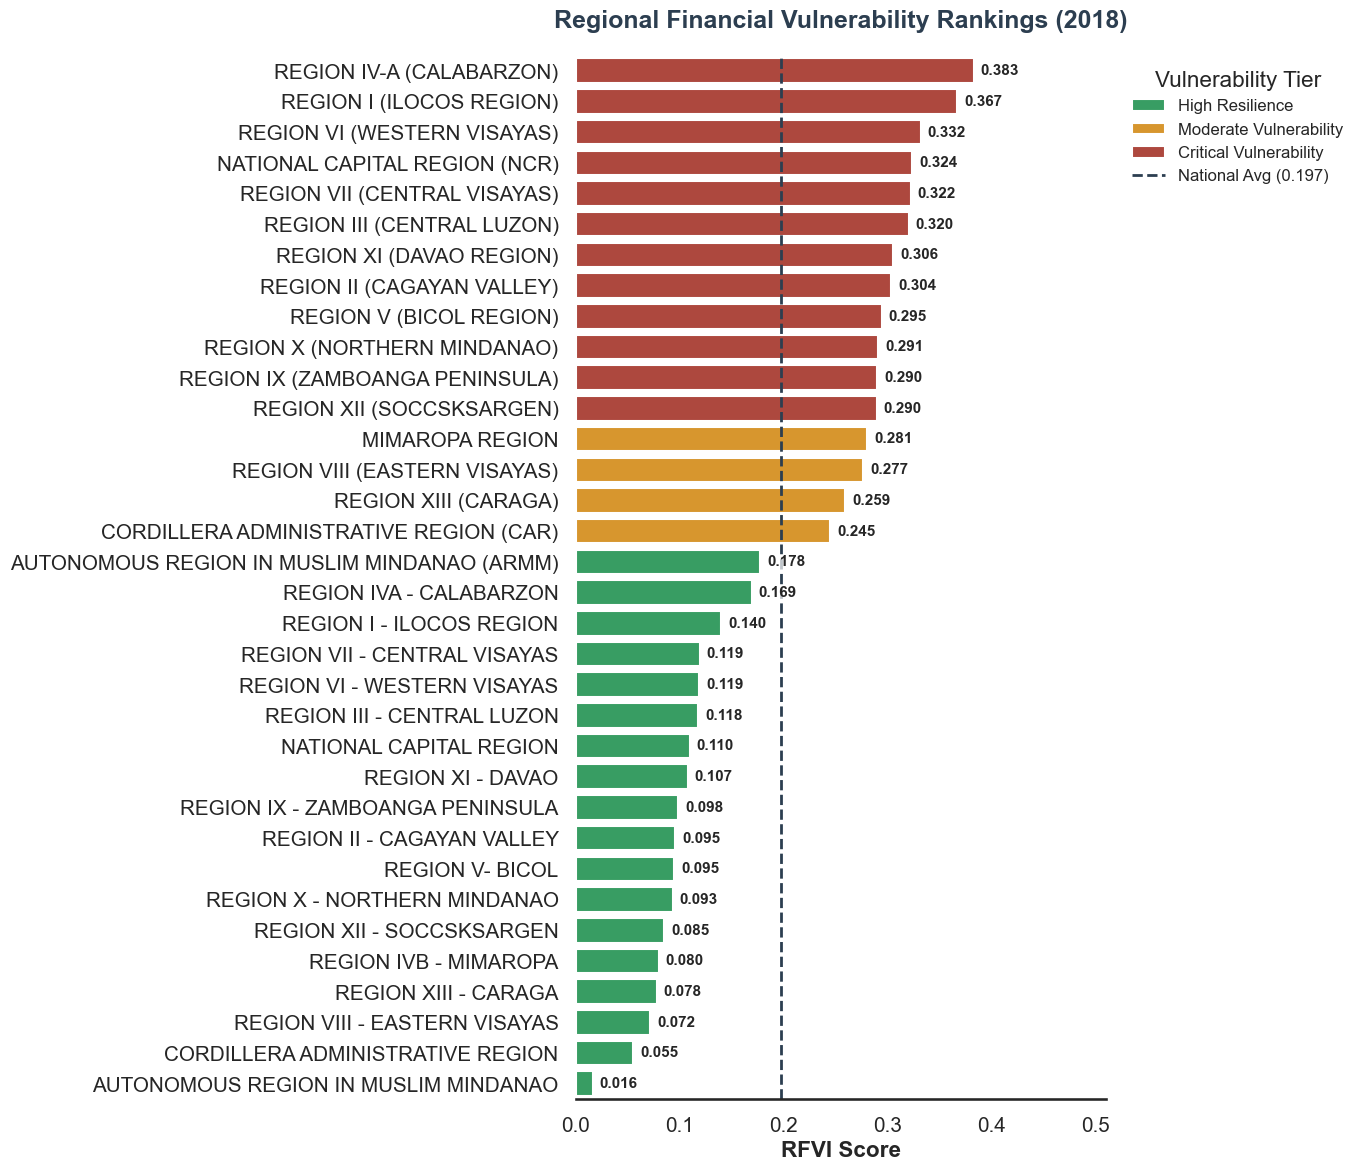

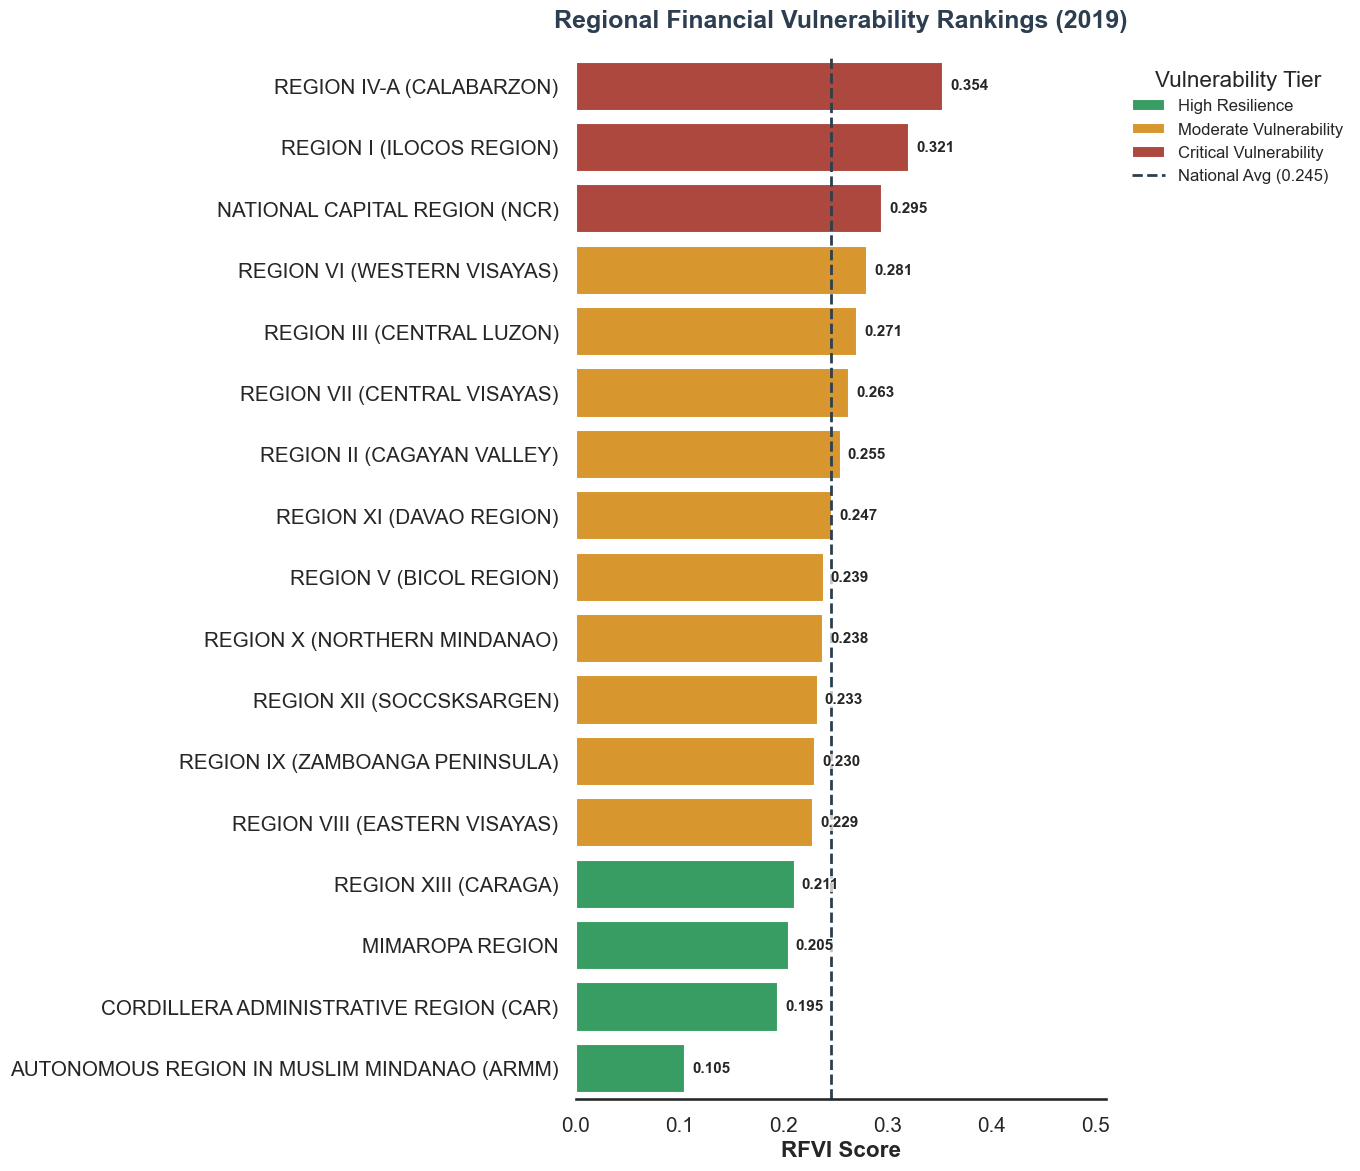

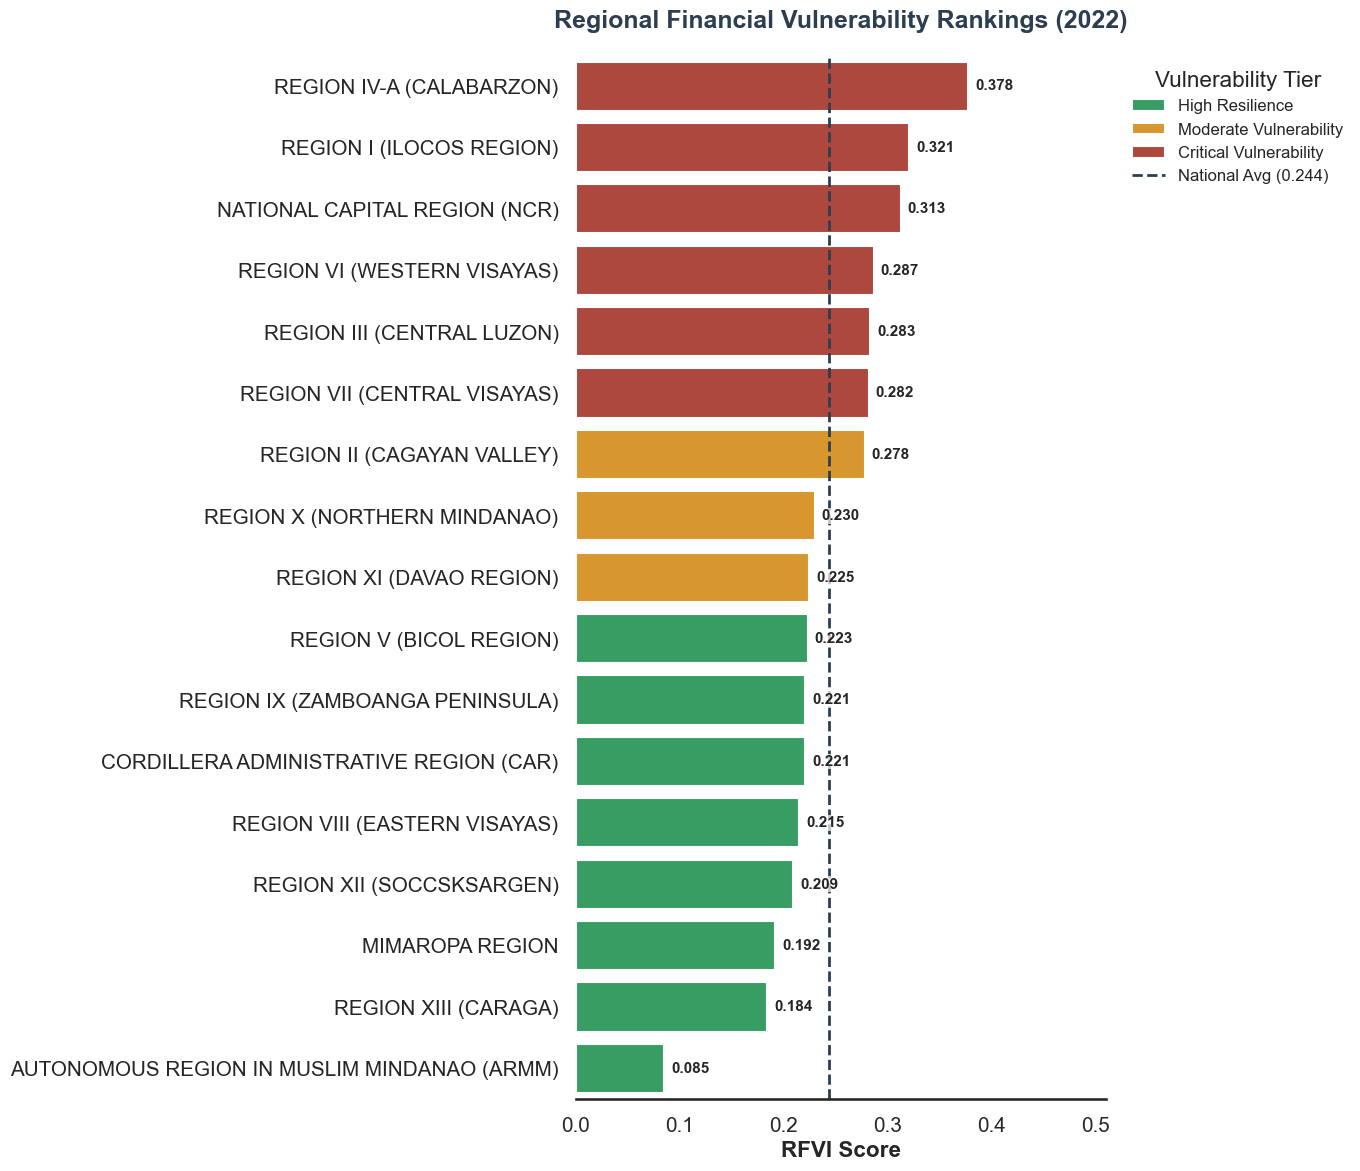

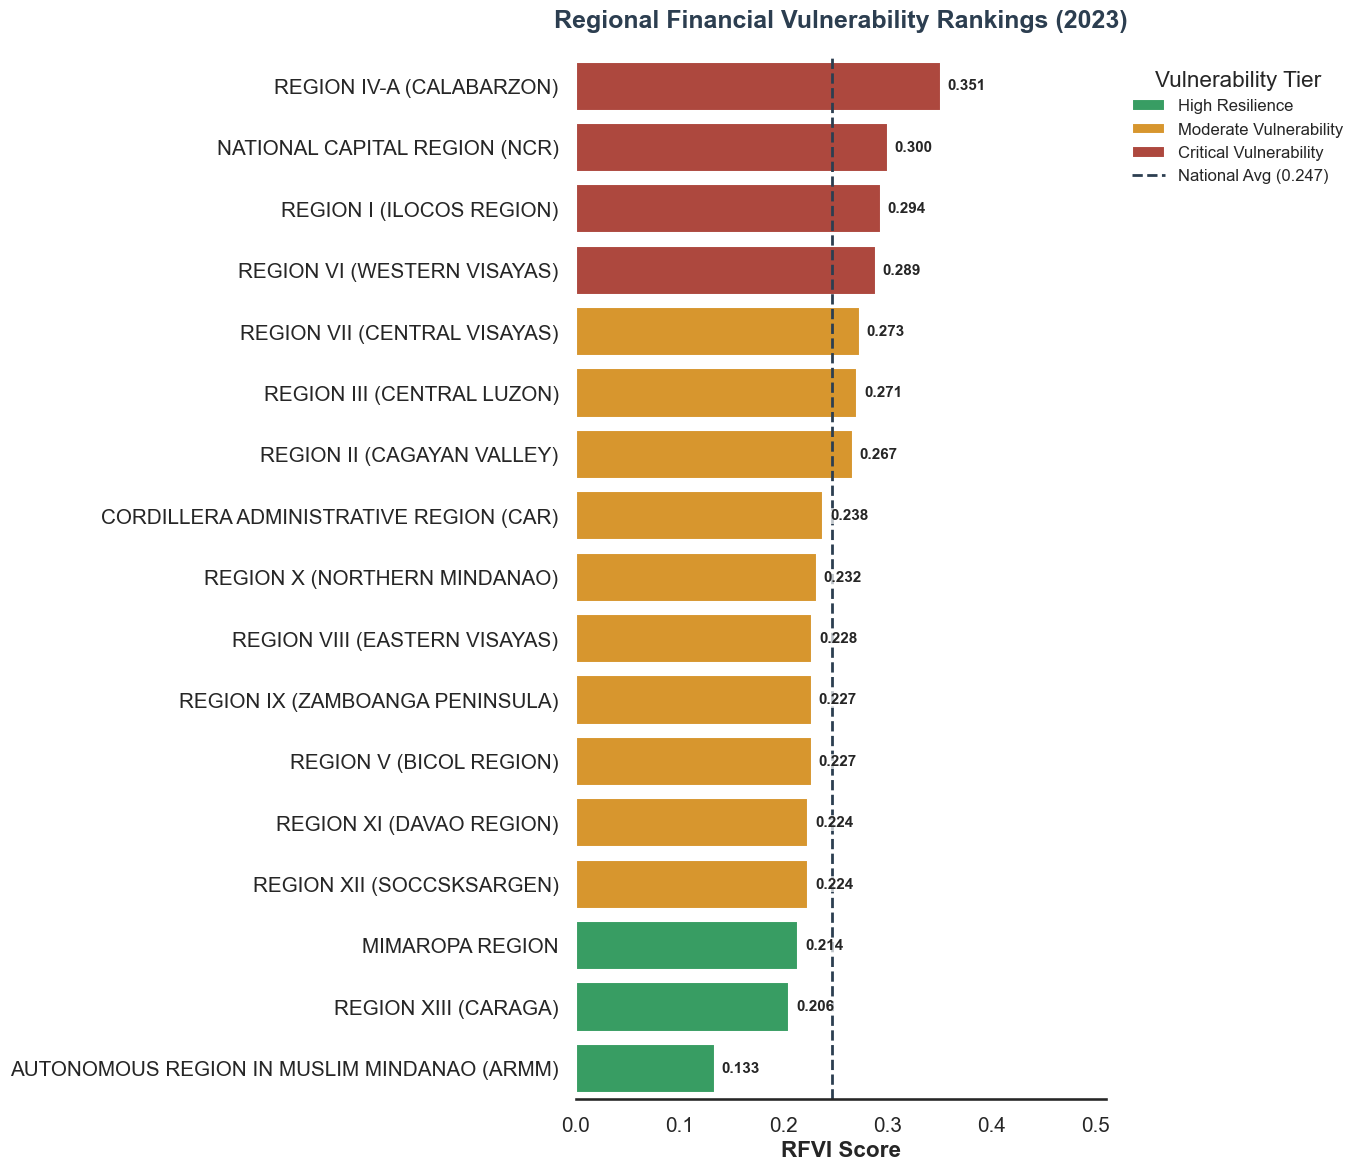

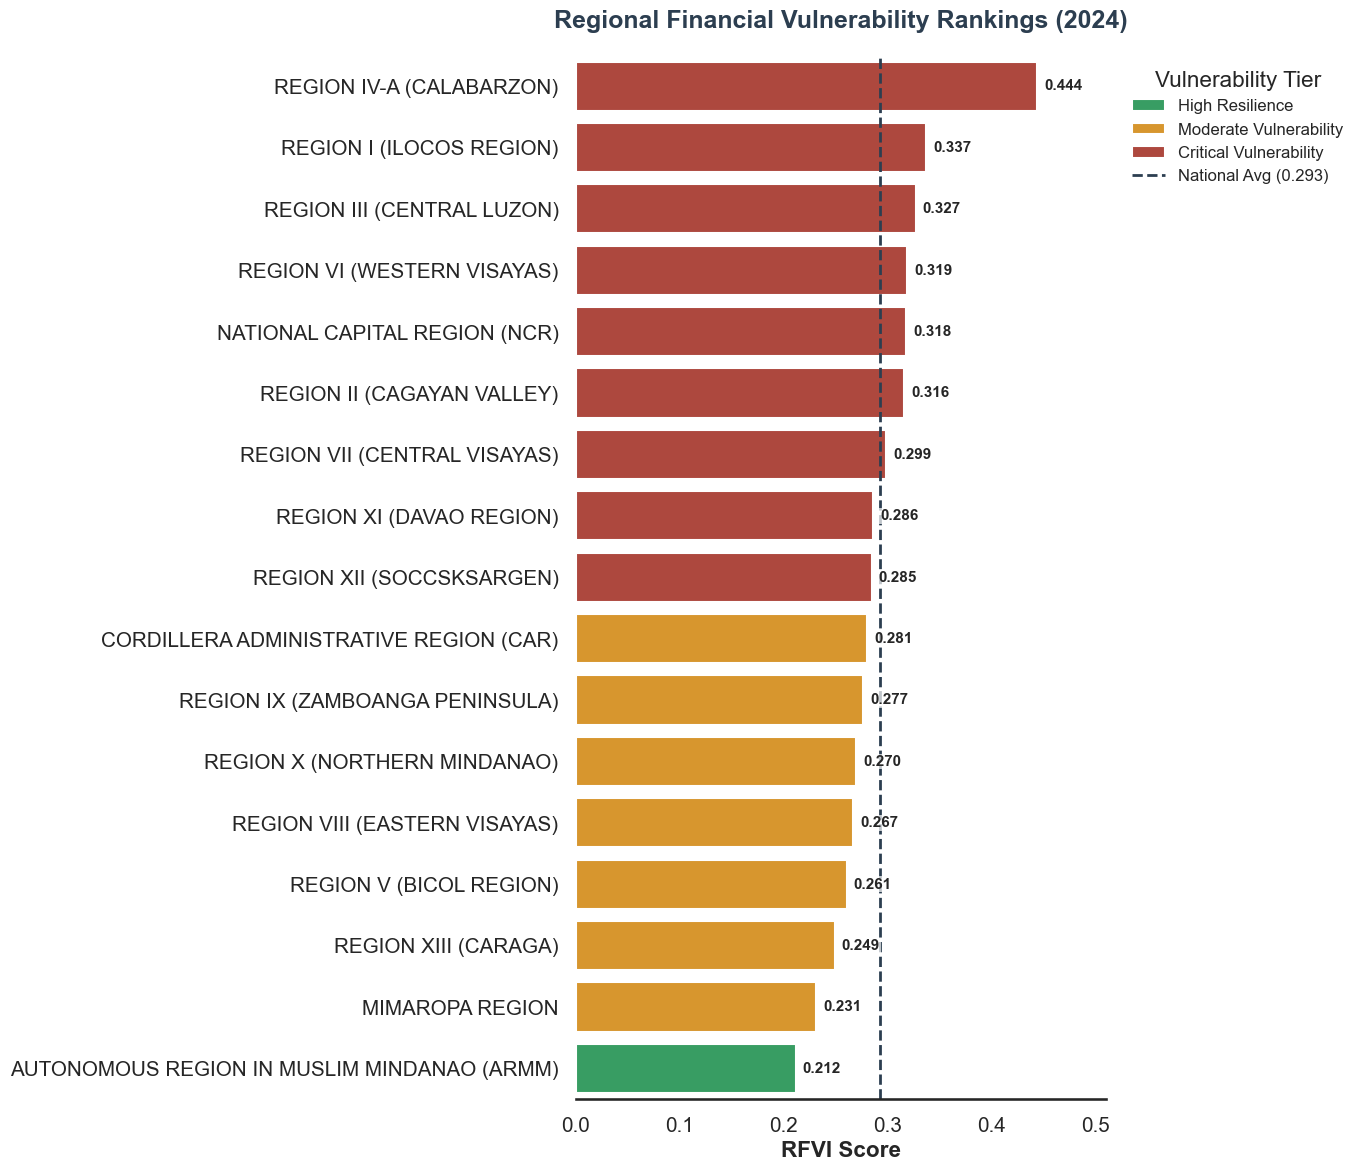

In [29]:
# --- Generate Ranking Bar Charts per Year ---
years = sorted(annual_df['Year'].unique())

for year in years:
    # Filter data for the specific year
    year_data = annual_df[annual_df['Year'] == year].sort_values('RFVI', ascending=False)
    
    plt.figure(figsize=(14, 12)) 
    
    ax = sns.barplot(
        data=year_data,
        y='region',
        x='RFVI',
        hue='Visual_Tier',
        dodge=False,
        palette=tier_palette,
        hue_order=tier_order
    )
    
    # Add value labels with white background for readability
    for container in ax.containers:
        labels = ax.bar_label(container, fmt='%.3f', padding=5, fontsize=11, fontweight='bold')
        for label in labels:
            label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))
            
    # Chart styling
    plt.title(f"Regional Financial Vulnerability Rankings ({year})", fontsize=18, fontweight='bold', pad=20, color='#2c3e50')
    
    # Add National Average line
    nat_avg = year_data['RFVI'].mean()
    plt.axvline(nat_avg, color='#2c3e50', linestyle='--', linewidth=2, label=f'National Avg ({nat_avg:.3f})')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, title="Vulnerability Tier", fontsize=12)
    plt.xlabel("RFVI Score", fontweight='bold')
    plt.ylabel(None)
    plt.xlim(0, annual_df['RFVI'].max() * 1.15) 
    
    sns.despine(left=True, bottom=False)
    plt.tight_layout()
    
    # Save and display
    plt.savefig(OUTPUT_DIR / f"Ranking_{year}.png", dpi=300)
    plt.show()
    plt.close()

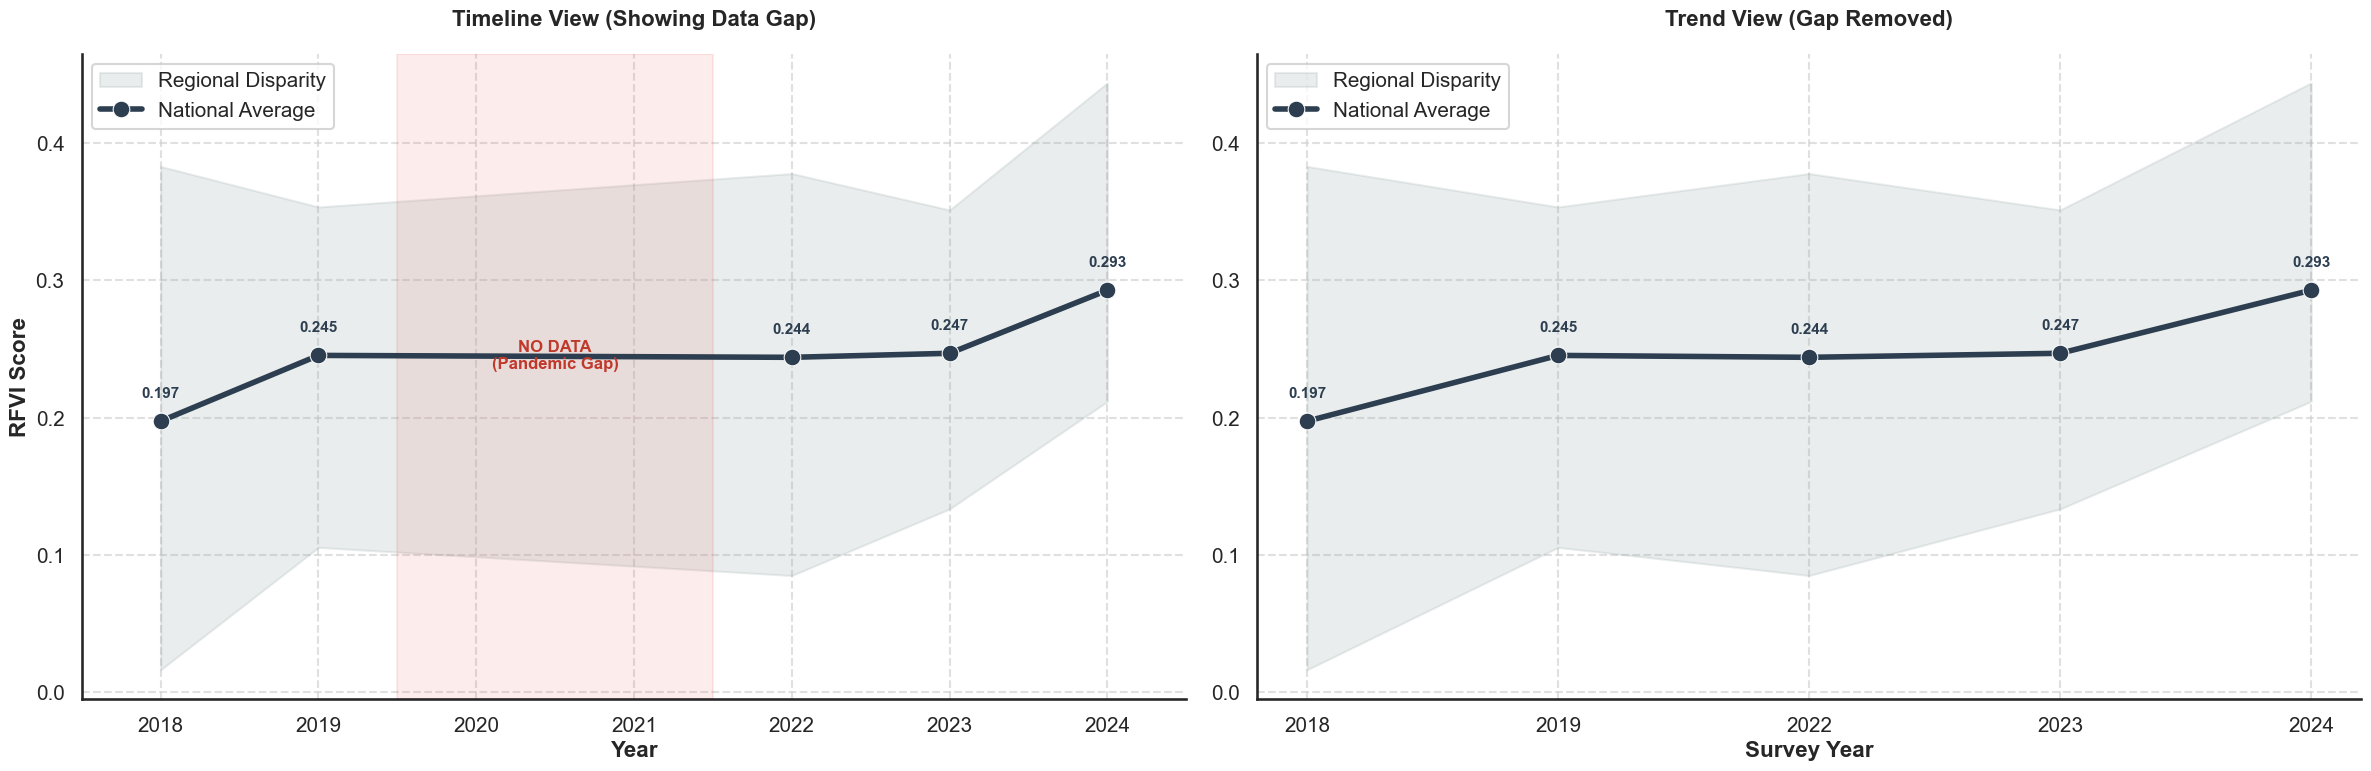

In [ ]:
import matplotlib.ticker as ticker

# --- National Trend Analysis ---
# Aggregate stats (mean, min, max) per year
national_trend = annual_df.groupby('Year')['RFVI'].agg(['mean', 'min', 'max']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# --- Plot A: True Timeline (With Data Gaps) ---
ax1 = axes[0]
ax1.fill_between(national_trend['Year'], national_trend['min'], national_trend['max'], color='#95a5a6', alpha=0.2, label='Regional Disparity')
sns.lineplot(data=national_trend, x='Year', y='mean', color='#2c3e50', linewidth=4, marker='o', markersize=12, ax=ax1, label='National Average')

# Annotations
for x, y in zip(national_trend['Year'], national_trend['mean']):
    ax1.text(x, y + 0.015, f'{y:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11, color='#2c3e50')

# Handle X-axis gaps (force integer ticks)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlim(2017.5, 2024.5)

# Mark pandemic gap if 2020 is missing
if 2020 not in national_trend['Year'].values:
    ax1.axvspan(2019.5, 2021.5, color='#e74c3c', alpha=0.1)
    ax1.text(2020.5, national_trend['mean'].mean(), "NO DATA\n(Pandemic Gap)", 
             ha='center', va='center', fontsize=12, color='#c0392b', fontweight='bold')

ax1.set_title("Timeline View (Showing Data Gap)", fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel("Year", fontweight='bold')
ax1.set_ylabel("RFVI Score", fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper left')
sns.despine(ax=ax1)

# --- Plot B: Continuous View (Gap Removed) ---
ax2 = axes[1]
x_idx = np.arange(len(national_trend)) # Create index for continuous plotting

ax2.fill_between(x_idx, national_trend['min'], national_trend['max'], color='#95a5a6', alpha=0.2, label='Regional Disparity')
sns.lineplot(x=x_idx, y=national_trend['mean'], color='#2c3e50', linewidth=4, marker='o', markersize=12, ax=ax2, label='National Average')

# Annotations
for x, y in zip(x_idx, national_trend['mean']):
    ax2.text(x, y + 0.015, f'{y:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11, color='#2c3e50')

# Map index back to Year labels
ax2.set_xticks(x_idx)
ax2.set_xticklabels(national_trend['Year'].astype(str))

ax2.set_title("Trend View (Gap Removed)", fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel("Survey Year", fontweight='bold')
ax2.set_ylabel(None)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(loc='upper left')
sns.despine(ax=ax2)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "Fig3_Comparison_Trends.png", dpi=300)
plt.show()

### 5. Interpreting the Results

This section explains the findings from our data analysis, focusing on how regions are grouped (RQ2) and ranked (RQ3).

#### **A. How to Read the Score (0.0 to 1.0)**
The Regional Financial Vulnerability Index (RFVI) is a simple score that measures financial risk.

* **0.0 (Safe):** A score close to 0 means the region is financially secure and can handle emergencies well.
* **1.0 (High Risk):** A score close to 1 means the region is financially fragile.
* **The Benchmark:** In our data, any score above **0.30** is considered a warning sign.

#### **B. The Three Regional Groups**
Our analysis found that regions fall into three clear categories based on their financial situation:

* **Group 1: The High Risk Regions (Red)**
    * **Who:** Big industrial hubs like **CALABARZON**, **Central Luzon**, and **NCR**.
    * **Why:** This finding is surprising but important. Even though these regions have high incomes, they are also the most vulnerable. This is likely because the cost of living is high, and households rely heavily on monthly salaries. If the economy slows down, they have very little buffer or savings to fall back on.

* **Group 2: The Average Regions (Orange)**
    * **Who:** Most provinces, such as **Central Visayas** and **Davao**.
    * **Why:** These regions are in the middle. They are currently stable, but they are not secure. A single major event, like a typhoon or a price spike, could easily push them into the High Risk category.

* **Group 3: The Resilient Regions (Green)**
    * **Who:** Regions like **ARMM** and **MIMAROPA**.
    * **Why:** These regions consistently show the lowest risk. This does not necessarily mean they are wealthy. It means they are less exposed to financial shocks. Families here may rely more on agriculture or local resources rather than volatile corporate jobs, making their survival less dependent on the national stock market or banking system.

#### **C. The Pattern (Scatterplot)**
The chart shows a very clear rule: **High Savings means Low Risk.**

* **Observation:** The regions with the lowest risk (Green dots) are always the ones with high Resilience (savings and assets).
* **The Problem:** The High Risk regions (Red dots) are vulnerable precisely because they lack this resilience. They have high expenses but not enough savings to match them.

#### **D. Changes Over Time (2018 to 2024)**
The trend line shows that financial security in the Philippines is declining.

* **The Trend:** The national risk score went up from **0.197 in 2018** to **0.293 in 2024**.
* **What it Means:** Financial vulnerability has increased by nearly **50%** over the last six years. This indicates that despite economic recovery, the average region is now more fragile and less prepared for a crisis than it was before the pandemic.

#### **E. Recommendation**
Based on the data, we recommend the following:

1.  **Focus on the Big Regions:** Government support usually targets the poorest provinces. However, the data shows that **CALABARZON** and **Ilocos** currently have the highest financial risk scores. They need immediate attention.
2.  **Build Savings, Not Just Jobs:** The data proves that Resilience (savings) is the key to lowering risk. Programs should focus on helping households save money and get insurance, rather than just increasing their debt capacity.